# Tentative Results

## Configurations

- Test System: HP (2x Intel E5-2630 v2 @ 2.6GHz, 24 vCPUs, 64GB DDR3)
- SDD drive under test: 128GB - TOSHIBA THNSNJ128G8NU (S/N: 75AS1011T9HW)
- Filesystem: XFS
- RocksDB: 16B key size, 8KB value size, total 13081649 keys, data dir size 100.76GB
- RocksDB version: 5.14.3
- YCSB version: https://github.com/ljishen/YCSB @ d4168eb77c53e30b3792b9cff4bbb9be3818b510
- Maven version: 3.5.4
- Java version: 1.8.0_181, Oracle Corporation
- System info: Ubuntu 16.04.5 LTS, Linux pl2 4.4.132-0404132-generic #201805211041 SMP Mon May 21 10:42:56 UTC 2018 x86_64 x86_64 x86_64 GNU/Linux
- [YCSB workload parameter file](https://github.com/ljishen/ycsb-rocksdb/blob/master/analysis/data/workloadc/workloadc_13/myworkload), inherited from [read only workloadc](https://github.com/ljishen/YCSB/wiki/Core-Workloads), read 75% (~75GB) of the data set size
- [RocksDB options file](https://github.com/ljishen/ycsb-rocksdb/blob/master/analysis/data/workloadc/workloadc_13/OPTIONS), data are all in the column family **usertable**

#### FileSystem Information

```
$ xfs_info  /mnt/sda1
meta-data=/dev/sda1              isize=512    agcount=4, agsize=7812630 blks
         =                       sectsz=512   attr=2, projid32bit=1
         =                       crc=1        finobt=1 spinodes=0
data     =                       bsize=4096   blocks=31250518, imaxpct=25
         =                       sunit=0      swidth=0 blks
naming   =version 2              bsize=4096   ascii-ci=0 ftype=1
log      =internal               bsize=4096   blocks=15259, version=2
         =                       sectsz=512   sunit=0 blks, lazy-count=1
realtime =none                   extsz=4096   blocks=0, rtextents=0
```

Note that the sector size is 512 bytes.

## Distribution of Requested Block Sizes (Snapshots)

1.
--
     Kbytes              : count     distribution
         0 -> 1          : 0        |                                        |
         2 -> 3          : 0        |                                        |
         4 -> 7          : 3927125  |******************                      |
         8 -> 15         : 8342764  |****************************************|
        16 -> 31         : 28752    |                                        |
        32 -> 63         : 125      |                                        |
        64 -> 127        : 244      |                                        |

2.
--     
     Kbytes              : count     distribution
         0 -> 1          : 0        |                                        |
         2 -> 3          : 0        |                                        |
         4 -> 7          : 3928446  |******************                      |
         8 -> 15         : 8275748  |****************************************|
        16 -> 31         : 28146    |                                        |
        32 -> 63         : 220      |                                        |
        64 -> 127        : 248      |                                        |
        
Note: `->` means between.

## System Memory

Memory is almost filled up with page cache

```
$ free -mh
              total        used        free      shared  buff/cache   available
Mem:            62G        3.5G        1.6G         60M         57G         58G
Swap:          974M        967M        7.8M
```

## System CPU

~50% of iowait on average, which means the CPUs are far from saturated. 

The max device throughput: 248.200924248 MB/sec
The max YCSB throughput: 129260.294295 ops/sec


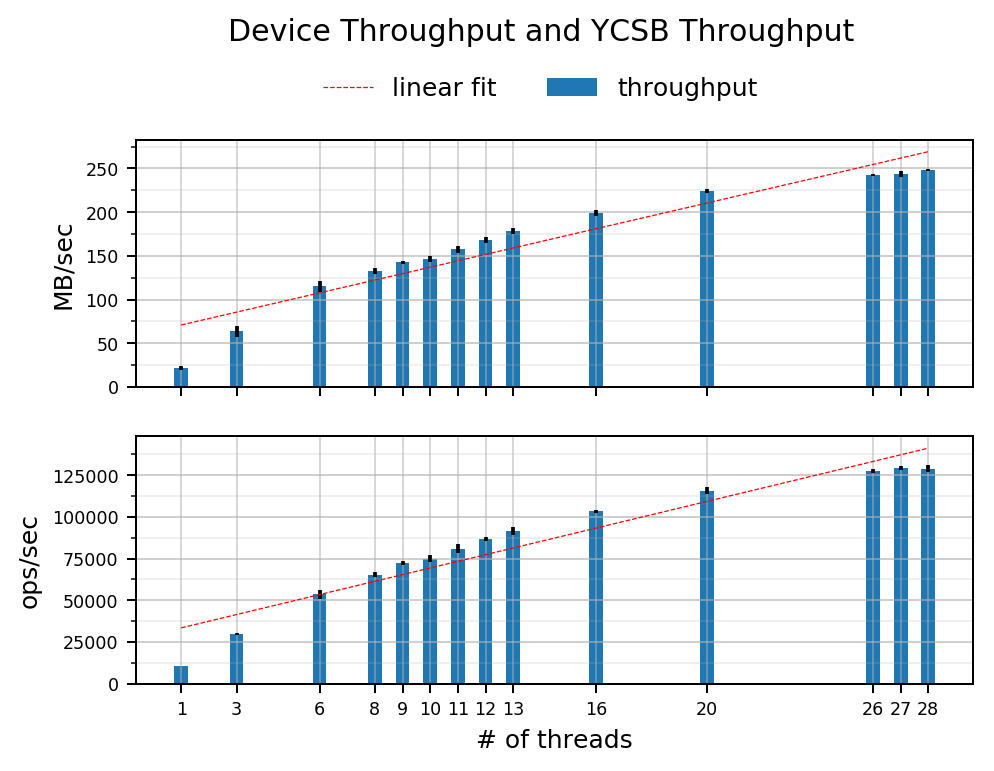

In [2]:
import glob
import re

import numpy as np
import matplotlib.pyplot as plt

from matplotlib.ticker import MultipleLocator


_SUFFIX = 'suf'
_VALUE = 'val'

_BEFORE = 'before'
_AFTER = 'after'

SECTOR_SIZE_KB = 0.5


def __get_read_mb(file_prefix):
    stat2val = {
        _BEFORE: {_SUFFIX: '_b.log', _VALUE: 0},
        _AFTER:  {_SUFFIX: '_a.log', _VALUE: 0}
    }
    for key, val in stat2val.items():
        with open(file_prefix + val[_SUFFIX], 'r') as fh:
            content = fh.read()
            stat2val[key][_VALUE] = int(content.split()[5])

    return (stat2val[_AFTER][_VALUE] - stat2val[_BEFORE][_VALUE]) * SECTOR_SIZE_KB / 1024


def __get_runtime_sec_and_throughput(trans_file):
    with open(trans_file, 'r') as fh:
        runtime = 0
        throughput = 0
        for line in fh:
            if 'RunTime' in line:
                # the `Runtime` value is in ms
                runtime = int(re.split(', *', line)[2]) / 1000
            elif 'Throughput(ops/sec)' in line:
                throughput = float(re.split(', *', line)[2])
                break

    return runtime, throughput


def __get_throughputs(dir, round):
    device_stats_file_prefix = dir + '/device_stats_round' + str(round)
    transactions_file = dir + '/transactions_round' + str(round) + '.dat'

    runtime, ycsb_throughput = __get_runtime_sec_and_throughput(transactions_file)
    return __get_read_mb(device_stats_file_prefix) / runtime, ycsb_throughput


def __get_rounds_in_ss_window(dir):
    profiles = glob.glob(dir + '/transactions_round[0-9]*.dat')

    if len(profiles) < 5:
        raise RuntimeError(
            'Not enough transaction profiles in ' + dir)

    rounds = []
    for profile in profiles:
        rounds.append(int(re.search(r'round(\d+)', profile).group(1)))

    return sorted(rounds)[-5:]


def __get_threadcount(dir):
    with open(dir + '/myworkload', 'r') as fh:
        for line in fh:
            if 'threadcount=' in line:
                return int(line.split('=')[1])


_DEVICE_THROUGHPUT = 'device_throughput'
_YCSB_THROUGHPUT = 'ycsb_throughput'

_MEAN = 'mean'
_STD = 'std'


def __get_avg_throughputs(dir):    
    rounds = __get_rounds_in_ss_window(dir)

    device_throughputs = []
    ycsb_throughputs = []
    for r in rounds:
        device_throughput, ycsb_throughput = __get_throughputs(dir, r)
        device_throughputs.append(device_throughput)
        ycsb_throughputs.append(ycsb_throughput)

    return __get_threadcount(dir), \
            {
                _DEVICE_THROUGHPUT: {
                    _MEAN: np.mean(device_throughputs),
                    _STD:  np.std(device_throughputs, ddof=1)
                },
                _YCSB_THROUGHPUT:   {
                    _MEAN: np.mean(ycsb_throughputs),
                    _STD:  np.std(ycsb_throughputs, ddof=1)
                }
            }


def __list_subfolders(folder):
    return glob.glob('../data/' + folder + '/' + folder + '_[0-9]*')


def plot_throughputs(folder):
    fig, axes = plt.subplots(2, 1, sharex='col')
    fig.set_dpi(180)

    dev_th_ax = axes[0]
    ycsb_th_ax = axes[1]

    tc2th = {}
    subfolders = __list_subfolders(folder)
    for subf in subfolders:
        threadcount, throughputs = __get_avg_throughputs(subf)
        tc2th[threadcount] = throughputs

    tcs = sorted(tc2th.keys())
    ths = []
    for tc in tcs:
        ths.append(tc2th[tc])

    width = 0.5

    lines = []

    means = [v[_DEVICE_THROUGHPUT][_MEAN] for v in ths]
    print('The max device throughput: ' + str(max(means)) + ' MB/sec')
    dev_th_ax.bar(tcs,
                  means, width,
                  yerr=[v[_DEVICE_THROUGHPUT][_STD] for v in ths],
                  label='throughput')
    lines.append(dev_th_ax.plot(tcs,
                                np.poly1d(np.polyfit(tcs, means, 1))(np.unique(tcs)),
                                label='linear fit'))

    means = [v[_YCSB_THROUGHPUT][_MEAN] for v in ths]
    print('The max YCSB throughput: ' + str(max(means)) + ' ops/sec')
    ycsb_th_ax.bar(tcs,
                   means, width,
                   yerr=[v[_YCSB_THROUGHPUT][_STD] for v in ths])
    lines.append(ycsb_th_ax.plot(tcs,
                                 np.poly1d(np.polyfit(tcs, means, 1))(np.unique(tcs))))

    plt.setp(lines, linewidth=0.5, linestyle='--', color='r')

    dev_th_ax.set_ylabel('MB/sec')
    dev_th_ax.tick_params(labelsize=7)
    dev_th_ax.yaxis.set_minor_locator(MultipleLocator(25))
    dev_th_ax.grid(which='major', alpha=0.5)
    dev_th_ax.grid(which='minor', alpha=0.2)

    ycsb_th_ax.set_ylabel('ops/sec')
    ycsb_th_ax.tick_params(labelsize=7)
    ycsb_th_ax.yaxis.set_minor_locator(MultipleLocator(12500))
    ycsb_th_ax.grid(which='major', alpha=0.5)
    ycsb_th_ax.grid(which='minor', alpha=0.2)

    plt.xlabel('# of threads')
    plt.xticks(tcs)
    plt.suptitle('Device Throughput and YCSB Throughput', y=1.05)

    plt.figlegend(loc=8,
                  bbox_to_anchor=(0.5, 0.9),
                  frameon=False,
                  ncol=2)

    plt.show()


plot_throughputs('workloadc')

Here are the [baseline throughput performance](https://github.com/ljishen/SSSPT/blob/master/analysis/notebooks/conclusion.ipynb) of this drive:
<table>
<tr><td><b>4KB</b></td><td>161.7 MB/s</td></tr>
<tr><td><b>8KB</b></td><td>240.9 MB/s</td></tr>
<tr><td><b>16KB</b></td><td>320.9 MB/s</td></tr>
<table>